In [1]:
import torch

from optimum.quanto import freeze, qfloat8, quantize, qint8, qint4
 
from diffusers import FlowMatchEulerDiscreteScheduler, AutoencoderKL
from diffusers.models.transformers.transformer_flux import FluxTransformer2DModel
from diffusers.pipelines.flux.pipeline_flux import FluxPipeline
from transformers import CLIPTextModel, CLIPTokenizer,T5EncoderModel, T5TokenizerFast


fluxrepo_local = "black-forest-labs/FLUX.1-dev"
dtype = torch.bfloat16

scheduler = FlowMatchEulerDiscreteScheduler.from_pretrained(
    fluxrepo_local, 
    subfolder="scheduler"
)
text_encoder = CLIPTextModel.from_pretrained(
    fluxrepo_local, 
    subfolder="text_encoder", 
    torch_dtype=dtype
)
tokenizer = CLIPTokenizer.from_pretrained(
    fluxrepo_local, 
    subfolder="tokenizer", 
    torch_dtype=dtype
)
text_encoder_2 = T5EncoderModel.from_pretrained(
    fluxrepo_local, 
    subfolder="text_encoder_2", 
    torch_dtype=dtype
)
tokenizer_2 = T5TokenizerFast.from_pretrained(
    fluxrepo_local, 
    subfolder="tokenizer_2", 
    torch_dtype=dtype
)
vae = AutoencoderKL.from_pretrained(
    fluxrepo_local, 
    subfolder="vae", 
    torch_dtype=dtype
)
transformer = FluxTransformer2DModel.from_pretrained(
    fluxrepo_local, 
    subfolder="transformer", 
    torch_dtype=dtype
).to("cuda")

pipe = FluxPipeline(
    scheduler=scheduler,
    text_encoder=text_encoder,
    tokenizer=tokenizer,
    text_encoder_2=text_encoder_2,
    tokenizer_2=tokenizer_2,
    vae=vae,
    transformer=transformer,
)

/workspace/.venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2025-05-03 16:37:08.389219: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-05-03 16:37:08.389268: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-05-03 16:37:08.390452: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-05-03 16:37:08.397584: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimiz

In [2]:
pipe.load_lora_weights(
    "/workspace/my-Flux-LoRA-v5/checkpoint-700/", 
    weight_name="pytorch_lora_weights.safetensors")
#pipe.fuse_lora()

No LoRA keys associated to CLIPTextModel found with the prefix='text_encoder'. This is safe to ignore if LoRA state dict didn't originally have any CLIPTextModel related params. You can also try specifying `prefix=None` to resolve the warning. Otherwise, open an issue if you think it's unexpected: https://github.com/huggingface/diffusers/issues/new


In [3]:
## OOM on a 3090 if you don't quantize these two 
# print("quantizing transformer ..")
#quantize(pipe.transformer.to("cuda"), weights=qfloat8)
#freeze(pipe.transformer)

# print("quantizing text_encoder_2 ..")
#quantize(pipe.text_encoder_2.to("cuda"), weights=qfloat8)
#freeze(pipe.text_encoder_2)

pipe.to("cuda")

# pipe.enable_sequential_cpu_offload()
# pipe.vae.enable_slicing()
# pipe.vae.enable_tiling()

FluxPipeline {
  "_class_name": "FluxPipeline",
  "_diffusers_version": "0.33.1",
  "feature_extractor": [
    null,
    null
  ],
  "image_encoder": [
    null,
    null
  ],
  "scheduler": [
    "diffusers",
    "FlowMatchEulerDiscreteScheduler"
  ],
  "text_encoder": [
    "transformers",
    "CLIPTextModel"
  ],
  "text_encoder_2": [
    "transformers",
    "T5EncoderModel"
  ],
  "tokenizer": [
    "transformers",
    "CLIPTokenizer"
  ],
  "tokenizer_2": [
    "transformers",
    "T5TokenizerFast"
  ],
  "transformer": [
    "diffusers",
    "FluxTransformer2DModel"
  ],
  "vae": [
    "diffusers",
    "AutoencoderKL"
  ]
}

100%|██████████| 20/20 [00:41<00:00,  2.06s/it]


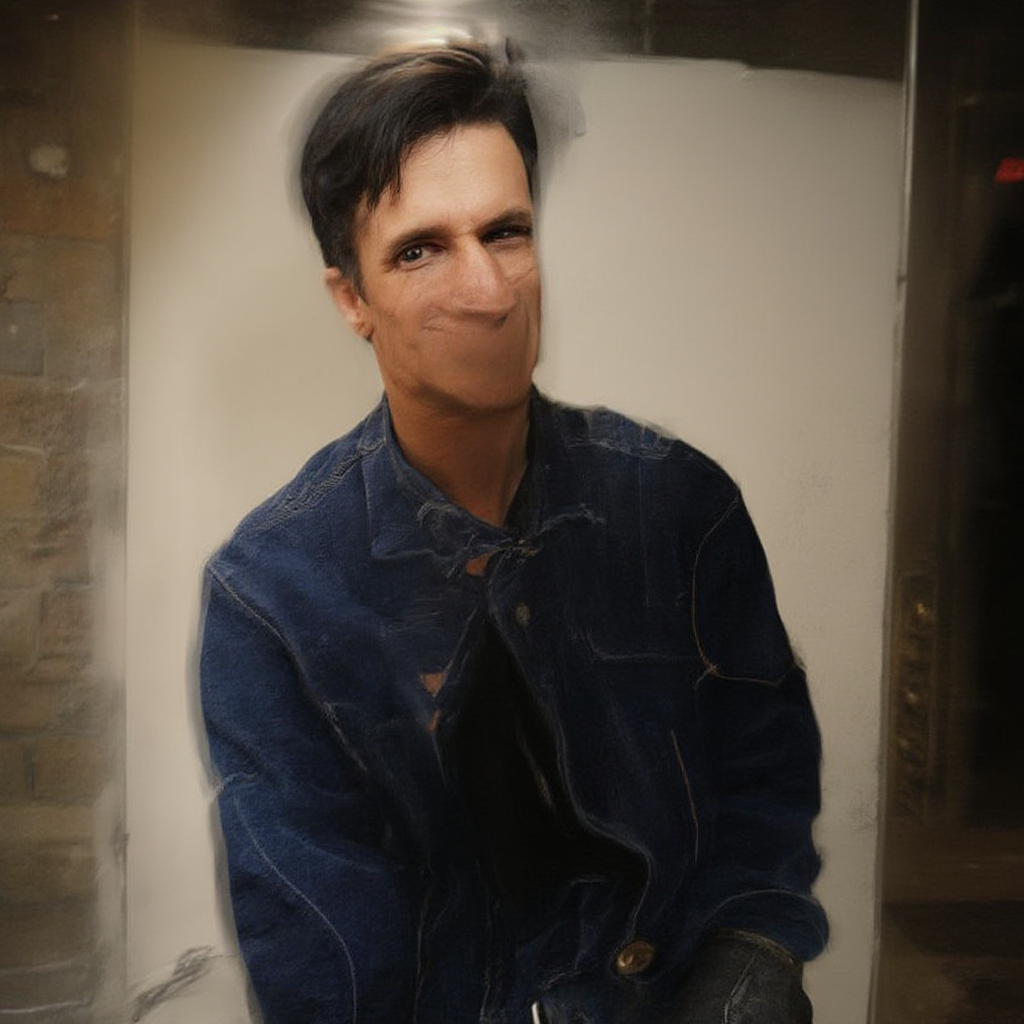

In [4]:
prompt = "photo of ohwx man standing in a studio setting"
seed = 42

image = pipe(
    prompt,
    height=1024,
    width=1024,
    guidance_scale=3.5,
    num_inference_steps=20,
    max_sequence_length=512,
    generator=torch.Generator("cpu").manual_seed(seed)
).images[0]
image